# Implementation and evaluation of K-nearest neighbors (KNN) algorithm for handwritten digit recognition.
### Nina Gutzeit, Maximimilian Hingerl, Emma Kray, Johannes Müller
### July 2021

## Introduction
(...)

In [52]:
# imports
%load_ext autoreload
%autoreload 2
from functions.Load_data import load_the_pickle
train_labels, train_values = load_the_pickle('data/train_points.p')
test_labels, test_values = load_the_pickle('data/test_points.p')
import  numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The data set
The data set consists of a training set of 60000 images and a test test with 10000 images. Each image is 28*28 pixels in size and the handwritten digits have been cropped to the center of the image. The data format is a csv file in which each row has the intensity values of the pixels of one image. The first column has the digit labels.

Below is a random sample of 25 images:

<Figure size 720x720 with 0 Axes>

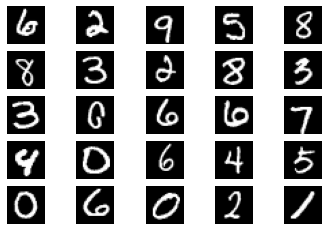

In [2]:
from vis_stan import sample_digits
# loading a selection of images
sample_digits()

## Data cleaning
The first step when dealing with such a data set is to check for errors or irregularities. Unexpected values such as NA values or outliers with intensity values outside of the range(0, 256) need to be dealt with. Possible solutions are removing the affected images or imputation of the individual values.   
There are no unusual entries:

In [3]:
# checking for NA and range


Other types of unusual data could include duplicate images:

Errors such as incorrect image labelling and image orientation are not accounted for.

## Standardization
The data needs to be standardized for PCA. It is important that all pixels have the same magnitude/ weight. For example if the intensity values of one pixel position vary from 0 to 5 and another has values between 100 and 150, then the second pixel will dominate the principle components.

Standardization can refer to different operations. It can refer to re-scaling the values to a certain range, subtracting the mean from each value and/ or dividing by the standard deviation. Here centering and Z-transformation were implemented with the goal of comparing their performance.

Covariance is calculated by:     
$$\text{cov}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \left(X_i - \overline{X}\right)\left(Y_i - \overline{Y}\right)$$   

The covariance operation includes centering: $ (X_i - \overline{X}) $. The same is true for Z transformation and correlation:  

$$ \dfrac{(X_i - \overline{X})} {\sigma _ {i}} ~~,~~~~~ \text{corr}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \dfrac {\left(X_i - \overline{X}\right)}{\sigma_{x}}\dfrac{\left(Y_i - \overline{Y}\right)}{\sigma_{y}} $$
  
The mean and standard deviation of the training data set are used to standardize the images of digits to be predicted. Therefore it was necessary to write functions with two arrays as an input. One matrix is standardized using the mean and std of the other matrix containing the training data.    

One challenge the data set provides is that there are pixel positions in the training data set where every image has the same intensity value. This means that the standard deviation is 0. Mathematically this leads to undefined values in the correlation matrix which the program returns as 'Nan'. Running the final algorithm over this data with the Nan values leads to a very poor result of less than 10% correct digit predicitions.    

However, these variables include no information that distinguishes a "1" from a "2" because the values are the same accross all digits. Therefore instead of replacing 'Nan's with another value, these variables could be removed entirely. The same variables need to be removed in the test images.

### Comparing standardization methods

In [4]:
#import vis_stan as vs

In [5]:
# Centered data performance on final algorithm:
#print('Correctly predicted digits: ', vs.hit_centered)
#print('Incorrectly predicted digits: ', vs.miss_centered)

In [6]:
# Z-transformed data performance:
#print('Correctly predicted digits: ', vs.hit_z)
#print('Incorrectly predicted digits: ', vs.miss_z)

Their performance is very similar, however the program is slightly more accurate when the data is only centered. To compare the 'quality' of the performances, here is a comparison of which digits are incorrectly identified:

In [7]:
# Centered missed digits vs Z transformed missed digits
#fig = plt.figure(figsize=(10, 10))
#plt.hist(vs.false_assignments_centered, bins= range(0,10))
#fig.ubplot(1,2,1)
#plt.hist(vs.false_assignments_z_transformed, bins= range(0,10))
#fig.subplot(1,2,2)

The distribution of falsely assigned digits is not noticeably different between the two methods. The plots reveal an interesting trend that some digits are more frequently mis-assigned than others.
Because the centered data performs better and does not require the removal of undefined values, it is selected as the default for the program.

## Principal Component Analysis

After the dataset was split and standardized, Principal Component Analysis (PCA) was applied. PCA is used to reduce the dimensionality of a data set while increasing its interpretability. The variables with the most directional variance are used to minimize the loss of information. The new uncorrelated variables, principal components, are calculated using eigenvalues/eigenvectors, where the eigenvectors are the principal components.

Eigenvectors are a set of vectors associated with a linear system of equations, such as a matrix. The idea behind an eigenvector is that given any matrix there is a set of n vectors $v_i$, that when multiplied with A results in a parallel/antiparallel vector to $v_i$. The resulting vectors length is then multiplied with the eigenvalue, which is some constant value. The mathematical definition of an eigenvector $v_i$ can be explained with the following equation:

$Av_i=λ_i v_i$

where A is the matrix and λ is the eigenvalue.

To calculate the eigenvector, first the eigenvalues need to be calculated. The formula

$det⁡(A-λI)=0$

can be used to calculate the eigenvalues. The determinant (det) of the difference between A and λ times I, the identity matrix, can be used to calculate the eigenvalues. The identity matrix consist of ones along the diagonal and zeros everywhere else. The solutions of λ are the corresponding eigenvalues for the matrix.

The last step is then calculating the eigenvectors using the eigenvalues. The formula

$Av_i=λ_i v_i$

is rearranged t

$(A-λ_i)\cdot v_i=0$

which, for example, for 2x2 matrix would looks like this:

\begin{pmatrix}
A-λ_i & A-λ_i\\
A-λ_i & A-λ_i
\end{pmatrix}
\begin{pmatrix}
v_{i,j}\\
v_{i,j}
\end{pmatrix}
= 0


From the resulting polynomial one can determine the eigenvector specific to the eigenvalue. The above calculation must be completed for every eigenvalue λ.

The variables `eigen_values, eigen_vectors` consist of the calculated eigenvalues and -vectors for the standardized train data set.

The eigenvectors are ranked based on their influence on the covariance of the data set. The eigenvectors with less significant directional variance are removed. This reduces the overall dimensionality.
```python
sorted_eigenvectors = eigen_vectors[:, sorted_index]
```
The above function sorts all eigenvectors based on greatest impact on variance.

The sorted eigenvectors are then reduced to the optimal number of components. The optimal number of components has the highest accuracy.

The function
```python
eigenvector_subset = sorted_eigenvectors[:, 0:num_components]
```
reduces the number of eigenvectors to the optimal number of principal components.
The attribute `train_evs` usually set to `train_evs=NONE`, which will be used during the iterations of the train set. When calling `PCA_func` on the test set, this attribute is set to `train_evs=train_evs`.
This then fullfiles the `if train_evs is not None` clause. The clause states:

```python
    if train_evs is not None:
        eigenvector_subset = train_evs
    X_reduced = np.dot(X_mean, eigenvector_subset)
    return X_reduced, eigenvector_subset
```

This code segment reduces the number of principal components of each test point to the before calculated subset of the training points.
At the end a matrix reduced to the number of principal components and the eigenvector subset are returned for further analysis.

The below 2D figures visualize the PCA for the test and train data sets. The colors correspond with a numerical digit. It is apperant from the graphs, that both the train and test data sets are similar as the color dispersal is similar.
The 3D graph is useful to understand how the PCA reduces the dimensionality of the data set. The actual dimensionality of the data set is much higher.

In [8]:
#import vis_pca as visp
#visp.components_test3.show()
#visp.components_test.show()
#visp.components_train.show()

## The knn algorithm

In [53]:
import functions.KNN_predict as knn
from functions.PCA import PCA_func
from functions.Standardize import center
import itertools
import multiprocessing
from scipy.spatial import KDTree

train_values = standardize(train_values)
test_values = standardize(test_values)

k = 5
n_pca = 30
# standardization and PCA:
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = PCA_func(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, Y=train_values)
test_values_pca, _ = PCA_func(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

### distance methods
The knn algorithm classifies the tested data based on the distances between a single test-datapoint and all points of the training dataset. These distances are then being sorted by
size and the k smallest distances were selected. By looking at the labels of these k nearest neighbours, the algorithm decides based on the major vote which label fits best for the tested data point.
There are many different ways to calculate distances, two methods were tested: The euclidean and the manhattan distance.

$d_{Euclidean}(x,y)= \sqrt{\sum^{n}_{i = 1}(x_i-y_i)^2} \\$
$d_{manhatten}(x,y)= \sum^{n}_{i = 1}|x_i-y_i| $

The knn algorithm delivers with both distance methods very good results, as seen below the algorithm performs slightly better when using the euclidean distance and correctly identifes 36 numbers more.
There was no big time difference between both methods. As the algorithm is better performing when using the euclidean distance, we  continued using it.

In [10]:
%%time

hit_euclidean = 0
miss_euclidean = 0
predicted_label = []
for i in range(10000):
    result = knn.knn("euclidean",train_values_pca,train_labels,test_values_pca[i],k)
    predicted_label.append(result)

for sample in range(10000):
    if predicted_label[sample] == test_labels[sample]:
        hit_euclidean += 1
    else:
        miss_euclidean += 1

Wall time: 4min 2s


In [11]:
%%time
hit_manhattan = 0
miss_manhattan = 0
predicted_label = []
for i in range(10000):
    result = knn.knn("manhattan",train_values_pca,train_labels,test_values_pca[i],k)
    predicted_label.append(result)

for sample in range(10000):
    if predicted_label[sample] == test_labels[sample]:
        hit_manhattan += 1
    else:
        miss_manhattan += 1
        

Wall time: 3min 58s


In [12]:
print("correctly classified vs wrongly classified numbers using  the euclidean distance:",hit_euclidean, "vs", miss_euclidean)
print("correctly classified vs wrongly classified numbers using the manhattan distance:",hit_manhattan, "vs", miss_manhattan)

correctly classified vs wrongly classified numbers using  the euclidean distance: 9765 vs 235
correctly classified vs wrongly classified numbers using the manhattan distance: 9729 vs 271


### ways of implementing knn

#### slow and simple code and the introduction of multiprocessing
The first version of the algorithm, which we used above, is a function which classifies one test data point at a time, each time calculating the 60.000 distance to the training points. The function needs to be run for each tested point which results in 10000 iterations resulting in a run time of over 4 minutes, depending on the used system.
To improve that, python multiprocessing was integrated into the functioning but slow algorithm. Instead of running one process that iterates 10000 times over the knn function,
the multiprocessing function gets a range of numbers with which it should run the function and than creates a "pool" of tasks and starts an individual python process for each batch of tasks. That means that based on the system which runs the code, the function creates multiple processes at once and splits the workload onto all processing cores of the computer.
For example on a computer with 4 cores the code can run 4 processes at a time efficently, due to that optimization we could bring down our run time from over 4 minutes to about 2 minutes as you can see below.

In [ ]:
%%time
hit_knn_multiprocessing = 0
miss_knn_multiprocessing = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.knn, zip(itertools.repeat("euclidean"), itertools.repeat(train_values_pca),itertools.repeat(train_labels),test_values_pca[range(10000),:],itertools.repeat(k)),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_multiprocessing += 1
            else:
                miss_knn_multiprocessing +=1
        print("correctly classified vs wrongly classified numbers using multiprocessing",hit_knn_multiprocessing, "vs", miss_knn_multiprocessing)

#### quick and complicated by introducing kd-trees
As we later on need to run the code several hundred times to optimize the number of n principles components and k nearest neighbours, we needed to bring down our run time even more.
The most time consuming parts were the calculation of 60000 distances and sorting them by size in each iteration. One method to circumvent calculating 60.000 distances works by building a kd-Tree once and than making a query for euch tested point.
A kd-tree is a k-dimensional tree is a space-partioning data structure used for organizing points. The k dimensions are represented by the n principal components in our case.
The kd-tree is a binary data structure which is constructed by splitting the data set along the median of the first dimension $x_1$ in two groups.
These groups are then being splitted again using the the median of the second dimension $x_2$ creating four groups.
By continuing this prodedure for each dimension $x_n$, a  tree-like structure is being generated, which can be saved into an variable.
When we now need to search for the k nearest neighbours of our tested data, we can quickly search for the nearest neighbours by going down the tree and comparing the medians of each dimension with the values of our tested data point. In the end we know in which subgroup of points we need to search for the k nearest neighbours, which reduces the amount of calculated and sorted distances drastically.
For building the kd-tree and making querys we used the KDTree and query function from the scipy.spatial package.
By using the kdtree we were able to bring down our processing time to about 24 s while still retainig the same accuracy.

In [50]:
%%time
tree = KDTree(train_values_pca)

hit_knn_kdtree = 0
miss_knn_kdtree = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.kdtree_knn, zip(test_values_pca[range(10000), :], itertools.repeat(k),itertools.repeat(train_labels), itertools.repeat(tree), itertools.repeat("euclidean")),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_kdtree += 1
            else:
                miss_knn_kdtree +=1
        print("result using a kdtree",hit_knn_kdtree, "vs", miss_knn_kdtree)

result using a kdtree 9803 vs 197
Wall time: 11.6 s



### optimal number of k and pcs
In order to improve the accuracy of our algorithm we needed to find the optimal number of k nearest neighbours and n principal components.
We did this by using two for loops to test accuracy using a range of values for k and n and iterating through them. We tested for 5 to 80 principal components and 2 to 12 k neighbours.
The code needed to run for about 7 hours and we saved the result as a list containing the number of correctly classified numbers for each pair of k and n.
To visualize this data we plotted a heatmap an a 3d plot of this data.


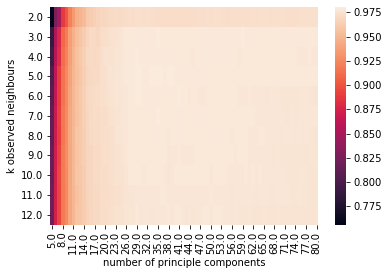

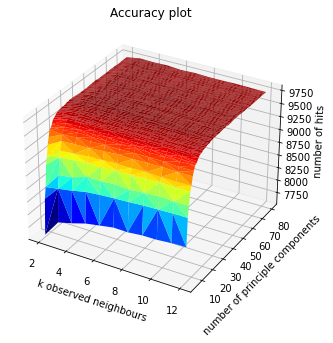

In [17]:
import functions.visualize_knn as vis_knn
#normal-mnist:
vis_knn.knn_heatmap("data/visualize_knn_mnist.npy",dropped_rows=[],dropped_columns = [])
vis_knn.knn_3dplot("data/visualize_knn_mnist.npy")


As you can see in both plots, the accuracy rises pretty quickly as the number of principle components increases and the number of k observed neighbours seems to be less important.
To better observe the area, where the accuracy quickly rises we plotted the selection of the same data again below.
Additionaly we can search in the saved data behind these plots for the absolute best n and k by using np.argsort.

highest accuracy/number of correctly identified images and the corresponding n and k values: [[  30    5 9803]]


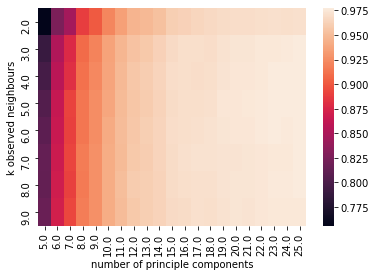

In [25]:
vis_knn.knn_heatmap("data/visualize_knn_mnist.npy",dropped_rows=([i for i in range(10,13)]),dropped_columns = ([i for i in range(26,81)]))

mydata = np.load("data/visualize_knn_mnist.npy")
print("highest accuracy/number of correctly identified images and the corresponding n and k values:",mydata[np.argsort(-mydata[:,2])[:1]])


As shown above we get the highest accuracy for 5 observed neighbours and 30 principle components resulting in 9803 correctly identified numbers.
The question is if that would be the best choice in a practical application, as the run time increases with a higher number of k neighbours an n principal components.
At the same time the accuracy improvement is very low, as you can see in the heatmap above.
To demonstrate this we ran the code again and timed it and comparedf the results below:

In [41]:
k = 5
n_pca = 30
# standardization and PCA:
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = PCA_func(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, Y=train_values)
test_values_pca, _ = PCA_func(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

In [55]:
%%time
tree = KDTree(train_values_pca)

hit_knn_30_5 = 0
miss_knn_30_5 = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.kdtree_knn, zip(test_values_pca[range(10000), :], itertools.repeat(k),itertools.repeat(train_labels), itertools.repeat(tree), itertools.repeat("euclidean")),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_30_5 += 1
            else:
                miss_knn_30_5 +=1


Wall time: 10 s


In [37]:
k = 3
n_pca = 20
# standardization and PCA:
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = PCA_func(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, Y=train_values)
test_values_pca, _ = PCA_func(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

In [38]:
%%time
tree = KDTree(train_values_pca)

hit_knn_3_20 = 0
miss_knn_3_20 = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.kdtree_knn, zip(test_values_pca[range(10000), :], itertools.repeat(k),itertools.repeat(train_labels), itertools.repeat(tree), itertools.repeat("euclidean")),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_3_20 += 1
            else:
                miss_knn_3_20 +=1


Wall time: 4.8 s


In [48]:
print("result using k=5 and n=30:",hit_knn_30_5, "vs", miss_knn_30_5)
print("result using k=3 and n=20",hit_knn_3_20, "vs", miss_knn_3_20)

result using k=7 and n=55: 9803 vs 197
result using k=4 and n=20 9687 vs 313


As expected with a lower k and less principle components the code runs much faster while still having a good accuracy.
In this example the "optimal" configuration with a k of 7 und 55 principal components took 22.4 s to run and had an accuracy of 97.65%.
The "time-saving" configuration with a k of 4 and 25 principal components took 7.74 s to run an had an accuray of 97.32%.
So in comparison the code ran about three times faster while only loosing 0.33% of the accuracy.
In an application where pictures need to be in real time or to improve the customer experience for end users it could be viable to sacrifice a bit of the accuracy to reduce the run time.

# Additonal tested stuff

## Weighted knn
The weighted knn algorithm is almost identical to the normal knn algorithm. The normal knn method solely counts the number labels of nearest neighbours and returns the major vote.
This doesn't take into account that closer neighbours might be more reliable in indicating the class of our tested data.
To take this into account we programmed a weighted KNN function based on inverse distance weighting.
For this additionally to the distance a weight is calculated fot the nearest neighbours by using this formula:

$\lambda_i(x,y) = \frac{1}{distance(x,y)^2} $

The weights are then beeing normalized:

$\lambda_{i}^*(x,y) = \frac{1}{\sum_{l=1}^{n}\lambda_l(x,y)} $

We implemented this and optimized the algorithm for the highest accuracy as before.

highest accuracy/number of correctly identified images and the corresponding n and k values:
 [[  34    4 9812]
 [  35    4 9810]
 [  33    4 9809]]


<AxesSubplot:xlabel='number of principle components', ylabel='k observed neighbours'>

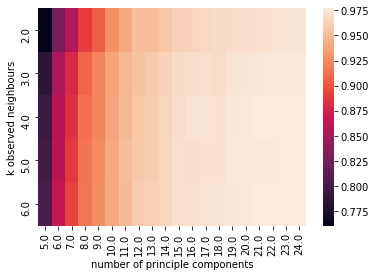

In [54]:
weighted_knn_data = np.load("data/visualize_weighted_knn.npy")
print("highest accuracy/number of correctly identified images and the corresponding n and k values:\n",weighted_knn_data[np.argsort(-weighted_knn_data[:,2])[:3]])
vis_knn.knn_heatmap("data/visualize_weighted_knn.npy",dropped_rows=([7, 8, 9, 10, 11, 12]),dropped_columns = ([25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]))

In [56]:
%%time
k = 4
n_pca = 34
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = PCA_func(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, Y=train_values)
test_values_pca, _ = PCA_func(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

hit_weightedknn = 0
miss_weightedknn = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.weighted_knn, zip(itertools.repeat("euclidean"), itertools.repeat(train_values_pca),itertools.repeat(train_labels),test_values_pca[range(10000),:],itertools.repeat(k)),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_weightedknn += 1
            else:
                miss_weightedknn +=1
        print("result using weighted knn:",hit_weightedknn, "vs", miss_weightedknn)
        print("result using normal knn:",hit_knn_kdtree, "vs", miss_knn_kdtree)

result using weighted knn: 9812 vs 188
result using normal knn: 9803 vs 197
Wall time: 1min 28s


As you can see above, our weighted knn function performed slightly better compared to the original knn function.
The weighted version was able to correctly classify 1 image more compared to the original version.
Overall the heatmap has the same characteristics as the one for the normal knn version, there were no drastic changes.


## Comparison fashion mnist
fashion mnist--> k=8  number of pcs = 77 hits=8679

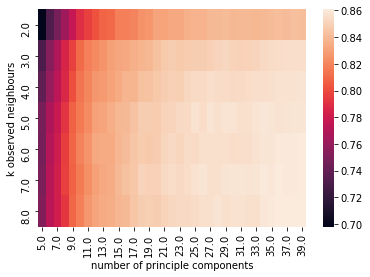

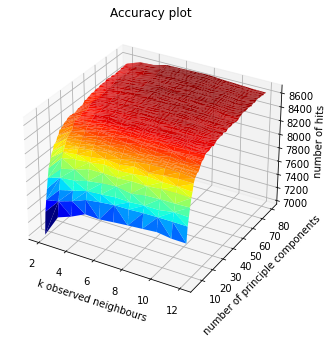

In [24]:
vis_knn.knn_heatmap("data/visualize_fashionmnist.npy",dropped_rows=([9, 10, 11, 12]),dropped_columns = ([40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]))
vis_knn.knn_3dplot("data/visualize_fashionmnist.npy")

## Phone numbers
One possible application of handwritten digit recognition is digitalising written information from documents like patient hospital forms, bank transfers or corona contact forms. This can speed up bureaucracy because an algorithm can work much faster than an employee manually typing the information into a computer.
Shown here is how the telephone number section of a form could work.
The form needs to have a section that the computer can read, the rest of the information is cropped. For phone numbers each box is a space in which a person can write one digit of their number.

The form is scanned in or the writing is done with a digital pen or a mouse. Then the image is cropped. Each digit is converted to a 28*28 pixel greyscale image, which is then inverted and flattened. The resulting array can be fed to the algorithm.

In [57]:
from functions.Phone_numbers import form_filled_in
from functions.Phone_numbers import call_me_maybe
from functions.Phone_numbers import show_phone_numbers

Here is an example phone number. The program correctly identifies all the digits:

In [58]:
digits = form_filled_in("digits/Phone number form example.png")
phone_number = call_me_maybe(digits)
print("Your phone number is:")
for i in phone_number:
    i = int(i)
    print(i, end='')

Your phone number is:
012345678990

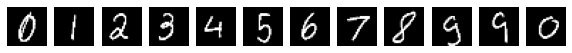

In [59]:
show_phone_numbers("digits/Phone number form example.png")

However, this is not always the case. Below is an example where the algorithm incorrectly predicts all 12 digits:

In [60]:
digits = form_filled_in("digits/Phone number form example 2.png")
phone_number = call_me_maybe(digits)

print("Your phone number is:")
for i in phone_number:
    i = int(i)
    print(i, end='')

Your phone number is:
682558223226

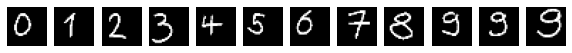

In [31]:
# The correct phone number:
show_phone_numbers("digits/Phone number form example 2.png")

First observations suggest the correct prediction rate is roughly at 8/12 digits correctly identified. For phone numbers this is a rather undesirable result, as a single error means that the number will not connect to the right person.
The accuracy seems to vary greatly between different handwriting. The examples above are written by two different people.
Interestingly the algorithm seems to be a lot better at predicting some numbers. 11/12 twos and fours are identified correctly, whereas barely 1/12 nines are recognized. This difficulty with 9s was noted before and is something worth looking into.

These numbers are based off of experimentation with our own handwriting and are therefore not representative.

There are a few reasons why the success of our digit recognition could be limited:
- digital writing tool rather than analogue like MNIST
- not optimally centered or cropped
- 60000 training digits is not enough
- "cultural" handwriting differences: crossing 7s, "capping" 1s

# Discussion

# References